In [1]:
!pip install pandas
!pip install matplotlib seaborn xgboost
!pip install scikit-learn

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     --------------------------------- ------ 51.2/61.2 kB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 61.2/61.2 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------------------------------------- 341.8/341.8 kB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.5 MB 15.2 MB/s eta 0:00:01
   ---- ----------------------------------- 1.2/10.5 MB 15.4 MB/s eta 0:00:01
   ------ --------------------------------- 1.8/10.5 MB 12.6 MB/s eta 0:00:01
   -------- ------------------------------- 2.3/10.5 MB 13.6 MB/s eta 0:00:01
   ----------- ---------------------------- 3.0/10.5 MB 12.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.6/10.5 MB 13.5 MB/s eta 0:00:01
   --------------- ------------------------ 4.1/10.5 MB 13.3 MB/s eta 0:00:01

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning model for weather prediction
import xgboost as xgb

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [4]:
# loading london weather data
df = pd.read_csv("london_weather.csv")

In [5]:
# convert 'date' column to string
df["date"] = df["date"].astype(str)

# create 'formattedDate' column by parsing the 'date' column
df["formattedDate"] = pd.to_datetime(df["date"], format='%Y%m%d')

# set the 'formattedDate' column as the index
df.set_index("formattedDate", inplace=True)

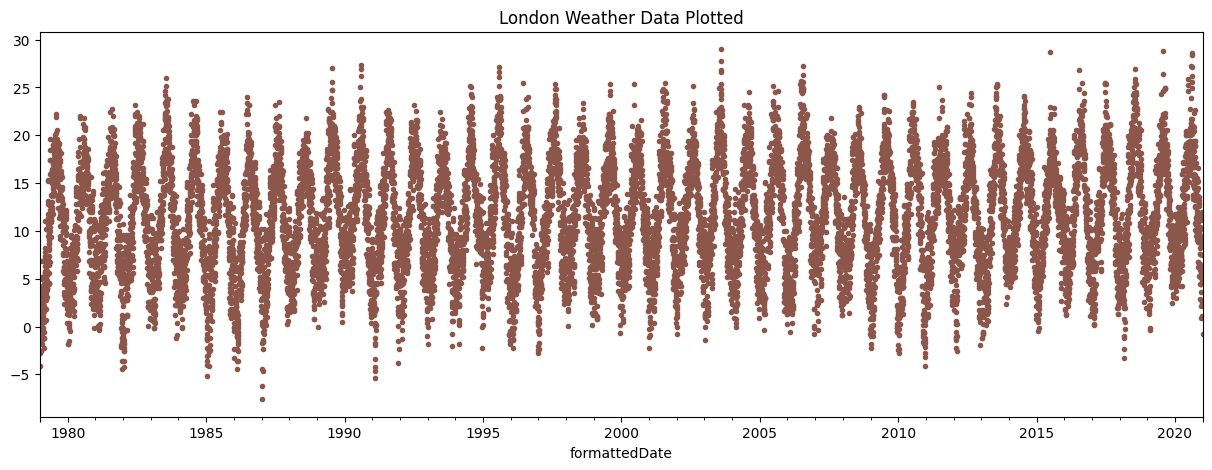

In [6]:
df['mean_temp'].plot(style='.', figsize=(15,5), color=color_pal[5], title= 'London Weather Data Plotted')
plt.show()

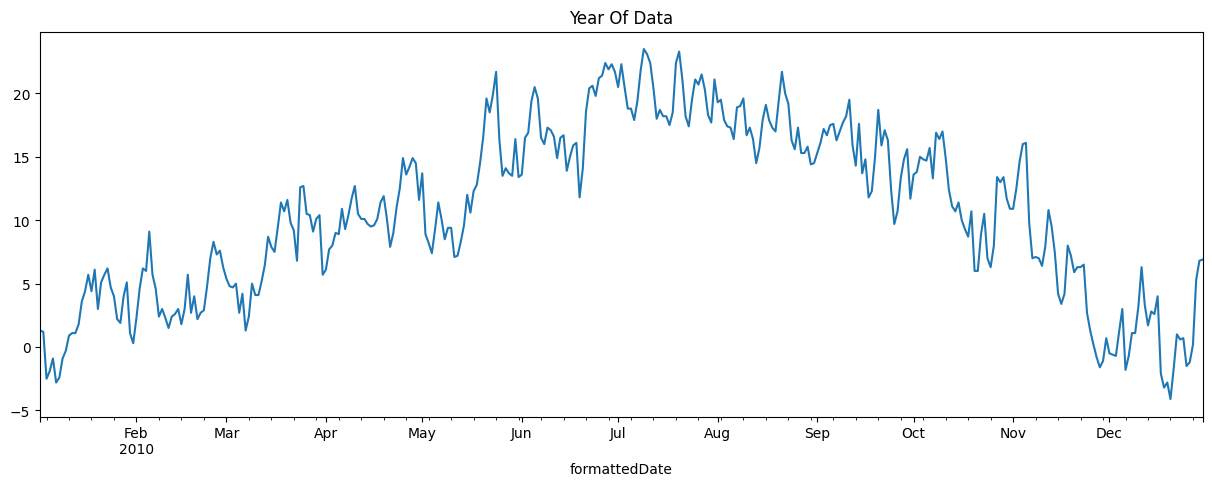

In [23]:
df['mean_temp'].loc[(df.index > '2010-01-01') & (df.index < '2010-12-31')] \
    .plot(figsize=(15, 5), title='Year Of Data')
plt.show()

In [21]:
# Time Series Cross Validation
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
df = df.sort_index()

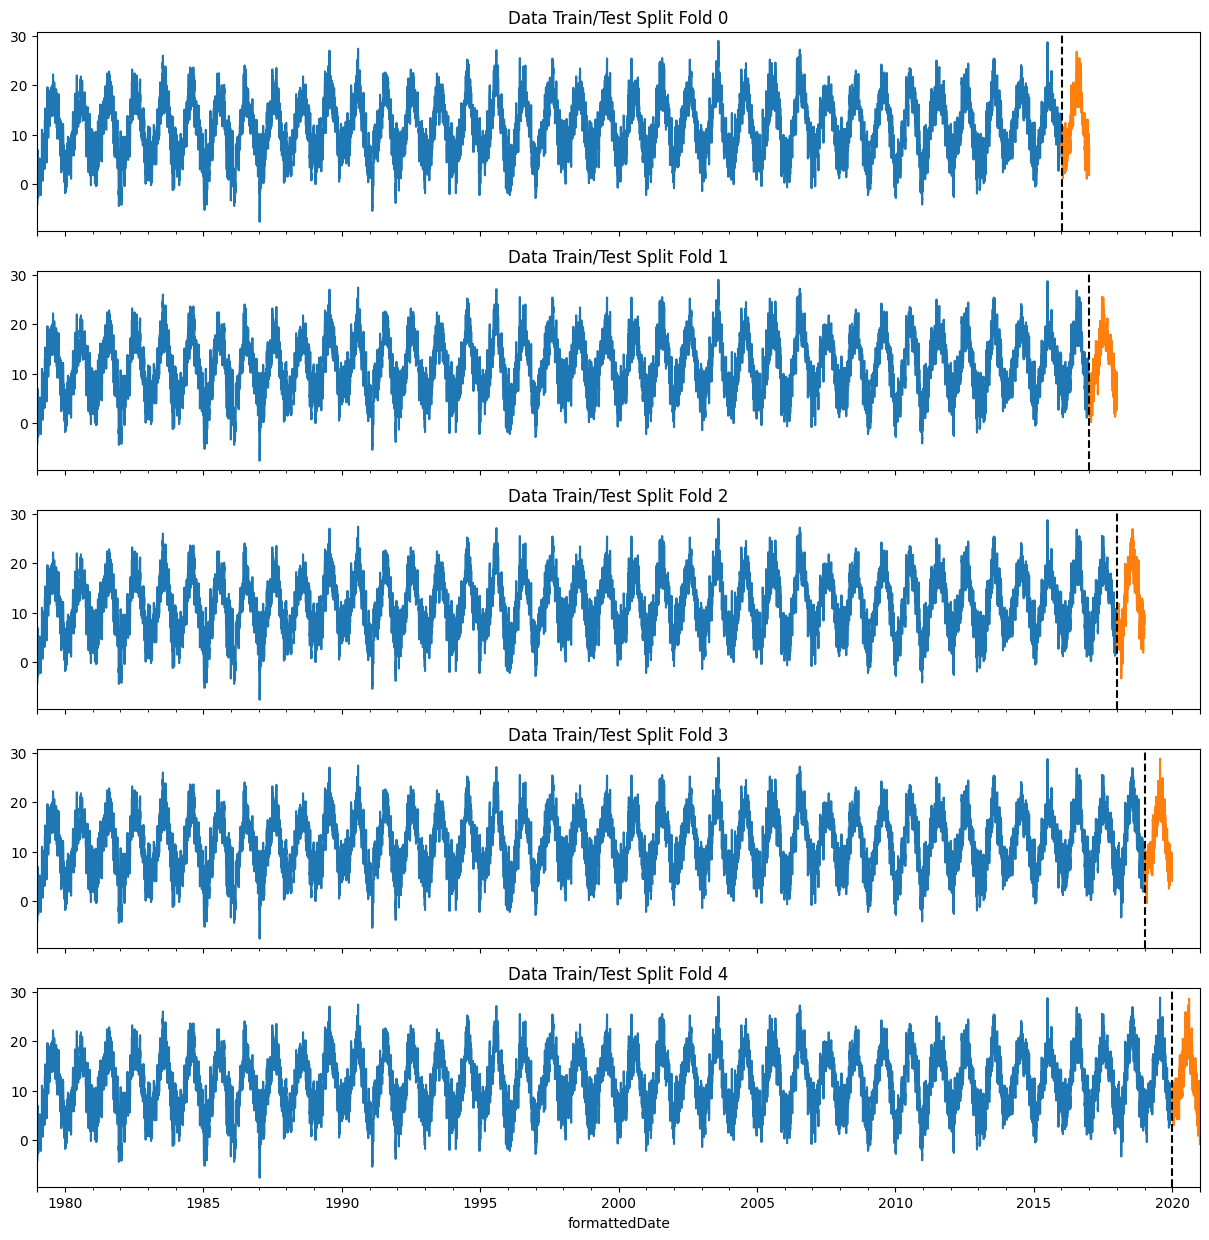

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['mean_temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['mean_temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [9]:
# Feature Creation
def create_features(df):
    """
    Create time series features based on the DataFrame index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df = create_features(df)

In [25]:
# Lag Features
def add_lags(df):
    target_map = df['mean_temp'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [27]:
df = add_lags(df)

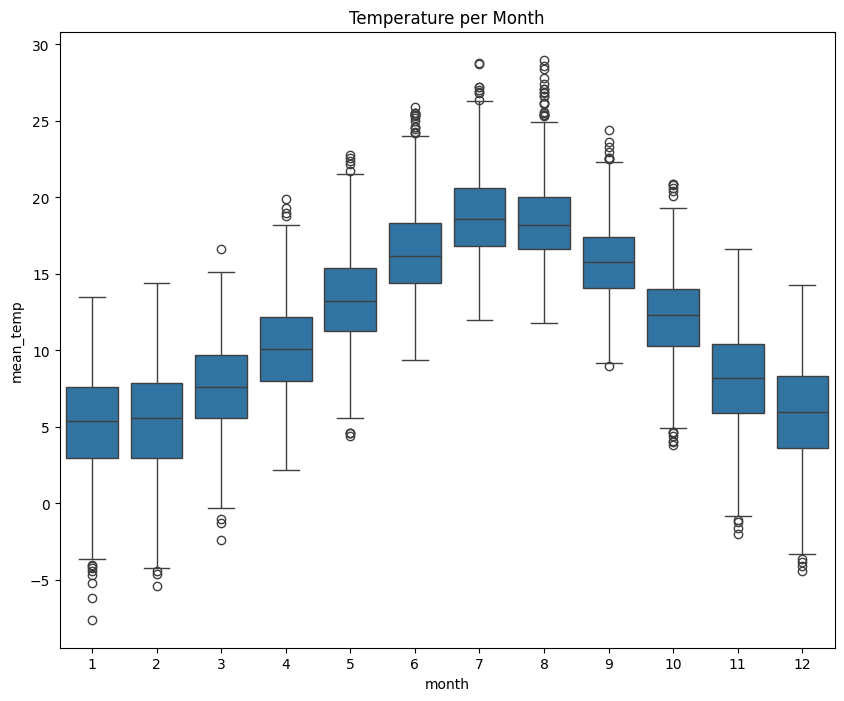

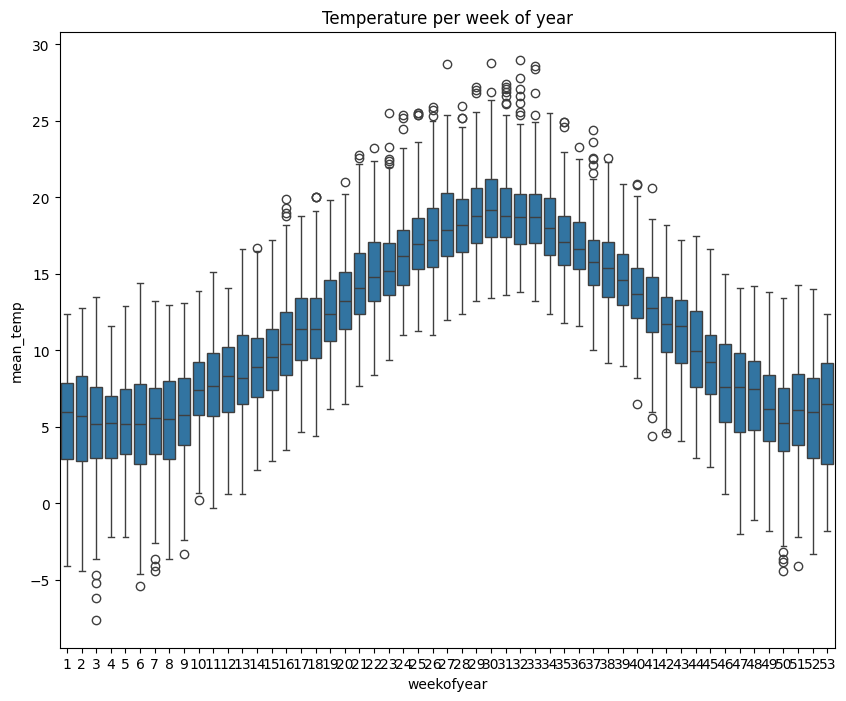

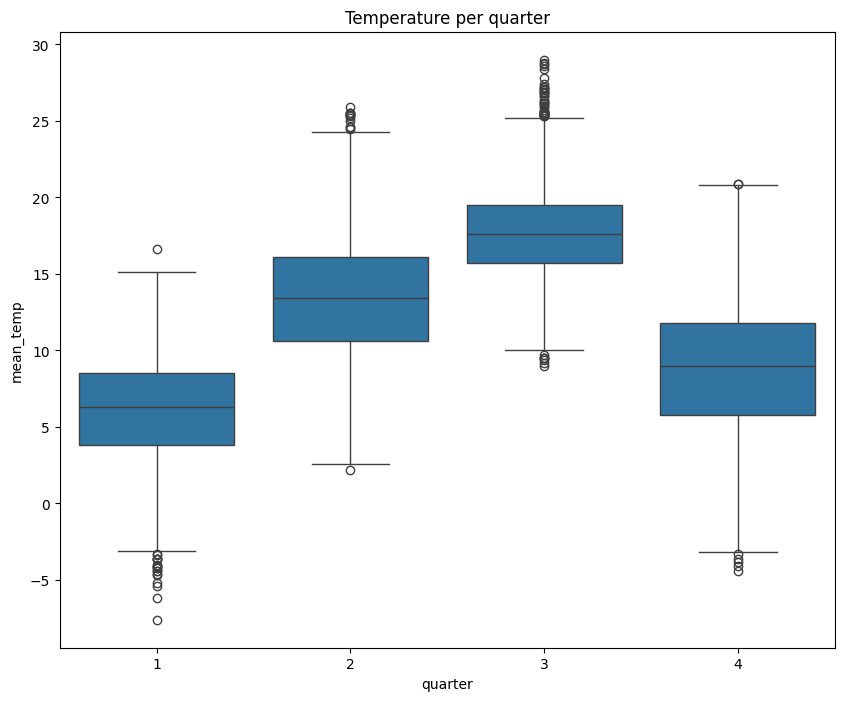

In [10]:
# Visualize our Feature/Target Relationship

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mean_temp')
ax.set_title('Temperature per Month')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='mean_temp')
ax.set_title('Temperature per week of year')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='mean_temp')
ax.set_title('Temperature per quarter')
plt.show()

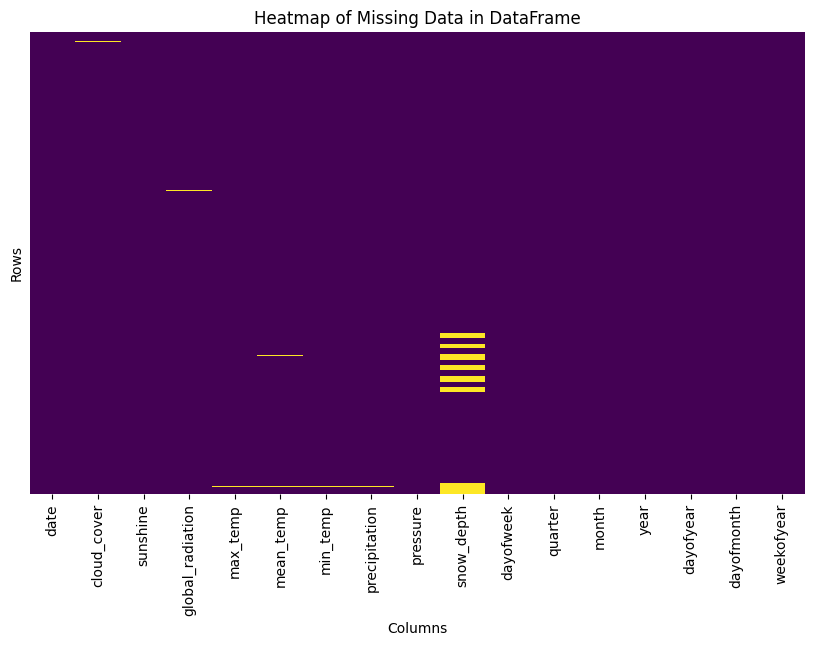

In [11]:
# created heatmap to visulaize the pattern of missing data
missing_data = df.isna()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')

# Add title and labels as needed
plt.title('Heatmap of Missing Data in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Display the plot
plt.show()

In [12]:
# the plot above shows that only a small proportion of rows are effected when NaN values are removed

In [32]:
# Create Our Model

tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'weekofyear' ,'dayofweek', 'dayofmonth' , 'quarter', 'month', 'year']
    TARGET = 'mean_temp'

    # Drop rows with NaN values in the features or the target
    train = train.dropna(subset=FEATURES + [TARGET])
    test = test.dropna(subset=FEATURES + [TARGET])

    # Prepare the training and test datasets
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:12.15876	validation_1-rmse:12.68108
[100]	validation_0-rmse:5.25890	validation_1-rmse:5.60487
[200]	validation_0-rmse:3.29831	validation_1-rmse:3.39866
[300]	validation_0-rmse:2.89377	validation_1-rmse:2.89381
[396]	validation_0-rmse:2.81053	validation_1-rmse:2.87081
[0]	validation_0-rmse:12.17267	validation_1-rmse:12.88483
[100]	validation_0-rmse:5.26050	validation_1-rmse:5.83637
[200]	validation_0-rmse:3.29647	validation_1-rmse:3.63457
[300]	validation_0-rmse:2.89523	validation_1-rmse:3.04916
[400]	validation_0-rmse:2.81091	validation_1-rmse:2.94596
[500]	validation_0-rmse:2.78031	validation_1-rmse:2.93543
[510]	validation_0-rmse:2.77826	validation_1-rmse:2.93528
[0]	validation_0-rmse:12.19133	validation_1-rmse:13.49219
[100]	validation_0-rmse:5.26655	validation_1-rmse:6.45515
[200]	validation_0-rmse:3.29770	validation_1-rmse:4.21090
[300]	validation_0-rmse:2.89581	validation_1-rmse:3.51797
[400]	validation_0-rmse:2.81373	validation_1-rmse:3.31905
[500]	validati

In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.9326
Fold scores:[2.854589479595105, 2.934015496250437, 3.221154485796773, 2.607399101677604, 3.0460474340134294]


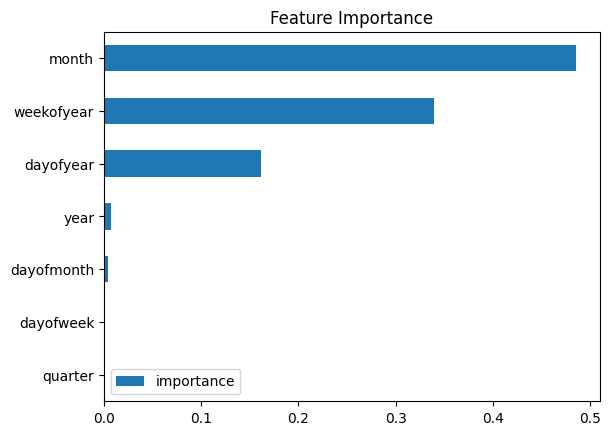

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [38]:
# Predicting the Future

# firstly retrain the model on all data

df = create_features(df)

FEATURES = ['dayofyear', 'weekofyear' ,'dayofweek', 'dayofmonth' , 'quarter', 'month', 'year']
TARGET = 'mean_temp'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=600, # model started to overfit around 600th iteration on average
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:12.24045	validation_1-rmse:13.28873
[100]	validation_0-rmse:5.28462	validation_1-rmse:6.24158
[200]	validation_0-rmse:3.30575	validation_1-rmse:4.01265
[300]	validation_0-rmse:2.90253	validation_1-rmse:3.33705
[400]	validation_0-rmse:2.82005	validation_1-rmse:3.14433
[500]	validation_0-rmse:2.78983	validation_1-rmse:3.08435
[599]	validation_0-rmse:2.77083	validation_1-rmse:3.05209


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
df.index.max()

Timestamp('2020-12-31 00:00:00')

In [42]:
# Create future dataframe
future = pd.date_range('2020-12-31','2021-12-01', freq='1D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [44]:
future_w_features = df_and_future.query('isFuture').copy()

In [47]:
# Predict the future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

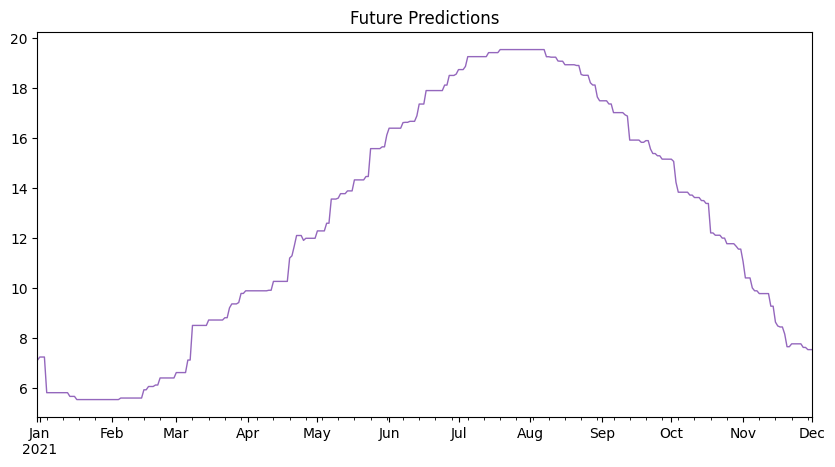

In [48]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [49]:
# Save model
reg.save_model('model.json')

In [53]:
!dir model.json

 Volume in drive C is Acer
 Volume Serial Number is 5681-0DDE

 Directory of C:\Users\tobic

16/12/2023  23:13           685,453 model.json
               1 File(s)        685,453 bytes
               0 Dir(s)  360,028,655,616 bytes free


<Axes: title={'center': 'Future Predictions'}>

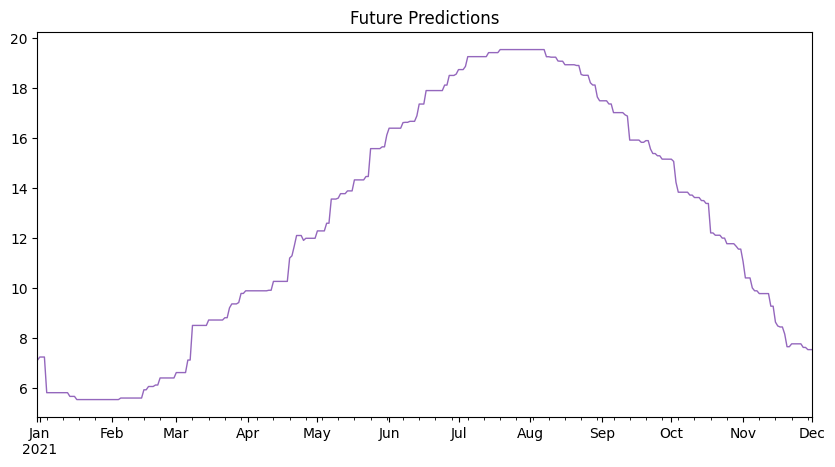

In [55]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')
future_w_features['pred'] = loaded_model.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')